<a href="https://colab.research.google.com/github/sampad-singha/Alzheimer_Disease_Detection/blob/main/ResNet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Mount Drive**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Create Dataset**

**Train Set**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds_dir = "/content/drive/MyDrive/small_dataset/augmented_train_sample"
# val_ds_dir = "/content/drive/MyDrive/archive_2/data/val"
test_ds_dir = "/content/drive/MyDrive/Sm_dataset/test_sample"

image_size = (224, 224)
batch_size = 32


train_ds = image_dataset_from_directory(
  train_ds_dir,
  labels = "inferred",
  label_mode = 'int',
  validation_split=0.2,
  subset="training",
  seed=1337,
  interpolation='bicubic',
  image_size=image_size,
  batch_size=batch_size,
  shuffle=True,
  pad_to_aspect_ratio = True,
)

Found 5528 files belonging to 4 classes.
Using 4423 files for training.


**Validation Set**

In [ ]:
val_ds =image_dataset_from_directory(
  train_ds_dir,
  labels = "inferred",
  label_mode = 'int',
  validation_split=0.2,
  subset="validation",
  seed=1337,
  interpolation='bicubic',
  image_size=image_size,
  batch_size=batch_size,
  shuffle=True,
  pad_to_aspect_ratio = True,
)

Found 5528 files belonging to 4 classes.
Using 1105 files for validation.


**Test Set**

In [ ]:
test_ds = image_dataset_from_directory(
  test_ds_dir,
  labels = "inferred",
  label_mode = 'int',
  seed=1337,
  interpolation='bicubic',
  image_size=image_size,
  batch_size=batch_size,
  shuffle=True,
  pad_to_aspect_ratio = True,
)

Found 3457 files belonging to 4 classes.


**Get Class Names**

In [ ]:
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


**Apply Ignore Errors**

In [ ]:
# Use ignore_errors directly
train_ds = (train_ds.ignore_errors())  # Directly use ignore_errors

# Iterate over the dataset
# for images, labels in train_ds.take(5):
#     print("Batch shape:", images.shape)
#     print("Batch labels:", labels.numpy())


**Visualizing Before Preprocesing**



# **3. Pre Processing**

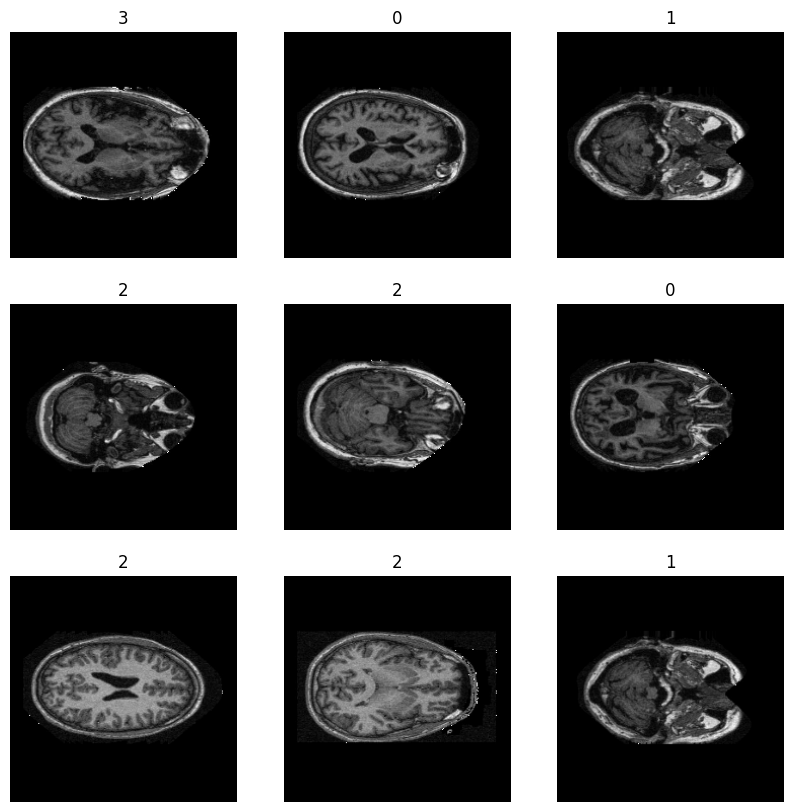

In [ ]:
#visualizing the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(int(labels[i]))
      plt.axis("off")

In [ ]:
# Rescaling values to [0-255]
def fix_pixel_values(image, label):
    image = tf.clip_by_value(image, 0.0, 255.0)  # Clamp values to [0, 255]
    return image, label
train_ds = train_ds.map(fix_pixel_values)
val_ds = val_ds.map(fix_pixel_values)
test_ds = test_ds.map(fix_pixel_values)

In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

# Preprocessing function
def preprocess_image(image, label):
    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)

    # Normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Clamp values to valid range
    image = tf.clip_by_value(image, 0.0, 1.0)

    # Contrast stretching
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    image = (image - min_val) / (max_val - min_val + 1e-5)  # Avoid division by zero

    # Apply Gaussian filter
    image = tfa.image.gaussian_filter2d(image, filter_shape=(5, 5), sigma=1.0)

    return image, label


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.17.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

ModuleNotFoundError: No module named 'keras.src.engine'

In [ ]:
# Normalization function
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label


In [ ]:
train_ds_processed = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_processed = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_processed = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

ValueError: in user code:

    File "<ipython-input-75-4a523d9723fb>", line 19, in preprocess_image  *
        image = tf.nn.dilation2d(

    ValueError: Shape must be rank 4 but is rank 5 for '{{node Dilation2D}} = Dilation2D[T=DT_FLOAT, padding="SAME", rates=[1, 2, 2, 1], strides=[1, 1, 1, 1]](ExpandDims, ones)' with input shapes: [1,?,224,224,1], [3,3,1,1].


# **4. Data Augmentation**

In [ ]:
import tensorflow as tf

def augment_image(image, label):
    # Random rotation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random brightness and contrast adjustments
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random cropping or resizing
    image = tf.image.resize_with_crop_or_pad(image, 256, 256)  # Ensure consistent size
    image = tf.image.random_crop(image, size=[224, 224, 1])

    # Random translation (width and height shifts)
    image = tf.image.resize(image, size=[224 + tf.random.uniform([], -20, 20, dtype=tf.int32),
                                         224 + tf.random.uniform([], -20, 20, dtype=tf.int32)])
    image = tf.image.resize(image, [224, 224])
    image = tf.clip_by_value(image, 0.0, 1.0)  # Clamp values to valid range

    return image, label


In [ ]:
# augment data
train_ds_aug = train_ds_processed.unbatch().map(augment_image).batch(batch_size)
# train_ds_aug = train_ds_aug.repeat()  # Infinite dataset


In [ ]:
for images, labels in train_ds_aug.take(1):
    print("Normalized min pixel value:", tf.reduce_min(images).numpy())
    print("Normalized max pixel value:", tf.reduce_max(images).numpy())

Normalized min pixel value: 0.0
Normalized max pixel value: 1.0


**Visualizing After Augmentation**

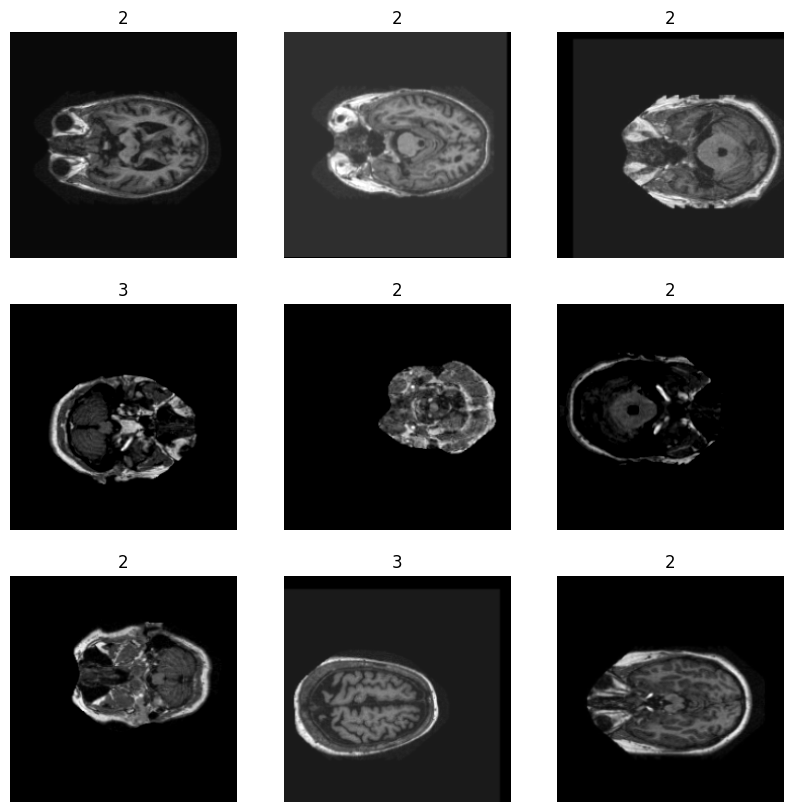

In [ ]:
#visualizing the data after preprocessing
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i], cmap="gray")
      plt.title(int(labels[i]))
      plt.axis("off")

# **5. Model**

In [ ]:
# Function to replicate 1 channel into 3 channels
def preprocess_grayscale_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

**ResNet50v2 Model**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [ ]:
resnet_model = Sequential()
pretrainted_model = keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(224, 224,3),
    pooling='max',
    weights="imagenet", #"imagenet"
    classes=4,
    name="resnet50v2",
)
for layer in pretrainted_model.layers:
    layer.trainable = False
resnet_model.add(layers.Lambda(preprocess_grayscale_to_rgb))
resnet_model.add(pretrainted_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 5
history = resnet_model.fit(
    train_ds_processed,
    validation_data=val_ds_processed,
    epochs=epochs)

Epoch 1/5
    139/Unknown 1307s 9s/step - accuracy: 0.5312 - loss: 2.4133

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1637s 12s/step - accuracy: 0.5318 - loss: 2.4069 - val_accuracy: 0.6932 - val_loss: 0.9245
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1021s 7s/step - accuracy: 0.7539 - loss: 0.7721 - val_accuracy: 0.7801 - val_loss: 0.6617
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 995s 7s/step - accuracy: 0.8337 - loss: 0.4756 - val_accuracy: 0.7330 - val_loss: 0.8714
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 998s 7s/step - accuracy: 0.8888 - loss: 0.2835 - val_accuracy: 0.8090 - val_loss: 0.5590
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1046s 7s/step - accuracy: 0.9274 - loss: 0.1966 - val_accuracy: 0.8145 - val_loss: 0.6540


In [ ]:
test_loss, test_accuracy = resnet_model.evaluate(test_ds_processed)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


109/109 ━━━━━━━━━━━━━━━━━━━━ 1181s 11s/step - accuracy: 0.6759 - loss: 1.3044
Test Loss: 1.3229821920394897, Test Accuracy: 0.6725484728813171


**DenseNet Model**

In [ ]:
# densenet_model = Sequential()
# denseNet = keras.applications.DenseNet121(
#     include_top=False,
#     input_shape=(224, 224,3),
#     pooling='max',
#     weights='imagenet', #"imagenet"
#     classes=4,
#     name="densenet121",
# )
# for layer in denseNet.layers:
#     layer.trainable = False
# densenet_model.add(denseNet)
# densenet_model.add(Flatten())
# densenet_model.add(Dense(512, activation='relu'))
# densenet_model.add(Dense(4, activation='softmax'))

In [ ]:
# densenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# epochs = 10
# history = densenet_model.fit(
#     train_ds_processed,
#     validation_data=val_ds_processed,
#     epochs=epochs)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


def load_and_preprocess_image(image_path):
    # Load the image from file
    img = image.load_img(image_path, target_size=(224, 224))  # Resize to the correct input size
    img_array = image.img_to_array(img)  # Convert the image to an array

    # Convert to grayscale (1 channel)
    img_array = tf.image.rgb_to_grayscale(img_array)  # Convert the image to grayscale

    # Normalize the image to [0, 1]
    img_array = img_array / 255.0

    # Add batch dimension: [1, height, width, channels]
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Example usage
image_path = '/content/drive/MyDrive/Sm_dataset/test_sample/Moderate Dementia/OAS1_0308_MR1_mpr-1_128.jpg'  # Path to the image you want to predict
preprocessed_image = load_and_preprocess_image(image_path)


In [ ]:
predictions = resnet_model.predict(preprocessed_image)

# If your model has multiple classes, you will get an array of probabilities
predicted_class_index = np.argmax(predictions, axis=1)  # Get the index of the class with the highest probability

predicted_class_label = class_names[predicted_class_index[0]]

# Display the predicted class
print(f'Predicted class: {predicted_class_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Very mild Dementia
